In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, f1_score, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS # а также другие алгоритмы
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

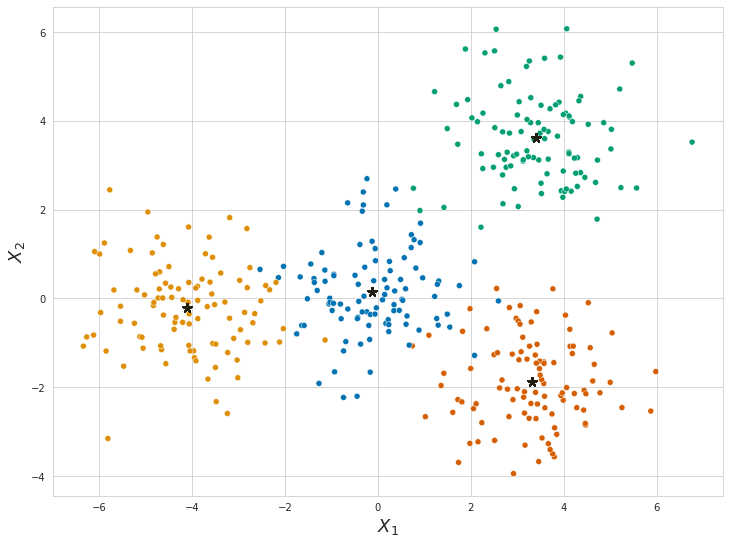

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [13]:
class MyKMeans:
    def __init__(self, n_clusters = 3, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            ## Iterate over all centroids and calcualate distances of our points from these clouds
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            ## concatenate by columns, where each columns ~ centroid
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        # Iterate over obtained centroids after multiple prediction and centroid "shiftings"
        for _ in range(self.max_iter):
            # Set new list of distances for chosen centroids
            pred_D = []
            ## Iterate over all closest centroids and calcualate distances of our points from these clouds
            for centroid in self.centroids:
                pred_D.append(self._calculate_distance(X, centroid))
            ## concatenate by columns, where each columns ~ centroid
            pred_D = np.concatenate(pred_D, axis=1)
            # For each X find label of closest cluster
            cluster_labels = np.argmin(pred_D, axis=1)

        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        # Our distance - difference of posisionts between each element and current centroid
        ## Have to make transposition for saving distances by columns (not rows)
        ### necessary for following concatenations
        dist = np.array(np.matrix(np.linalg.norm(X - centroid, axis = 1)).T)
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

In [14]:
toy_vis_random, toy_vis_sample = MyKMeans(n_clusters = 4, visualize = True, max_iter = 100), MyKMeans(n_clusters = 4, visualize = True, init = 'sample', max_iter = 100)
toy_lbl_random, toy_lbl_sample = MyKMeans(n_clusters = 4,  max_iter = 100), MyKMeans(n_clusters = 4, visualize = False, init = 'sample', max_iter = 100)

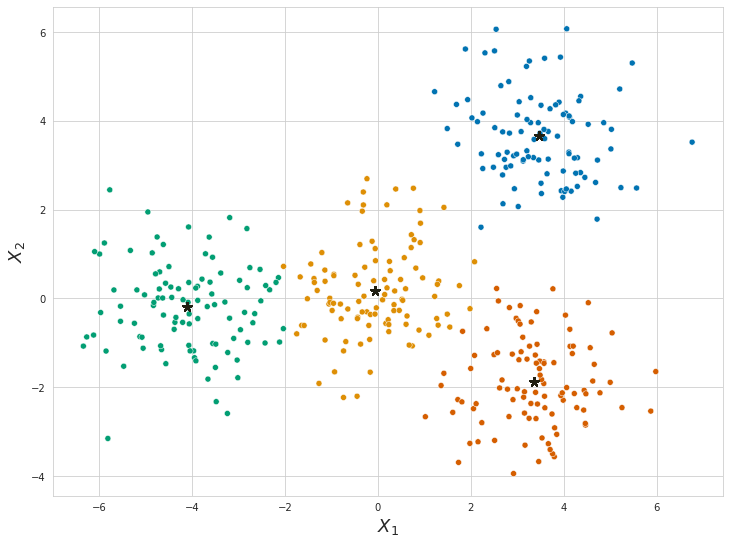

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
# Visualize random centroid search:
toy_vis_random.fit(X)

We see that when we randomly choose centroids and estimate distances from them we properly define clusters for our values. Such an algorithm runs fast and shifting analysis of the closest centroid and, constatnly, cluster provides a highly accurate clusterisation.

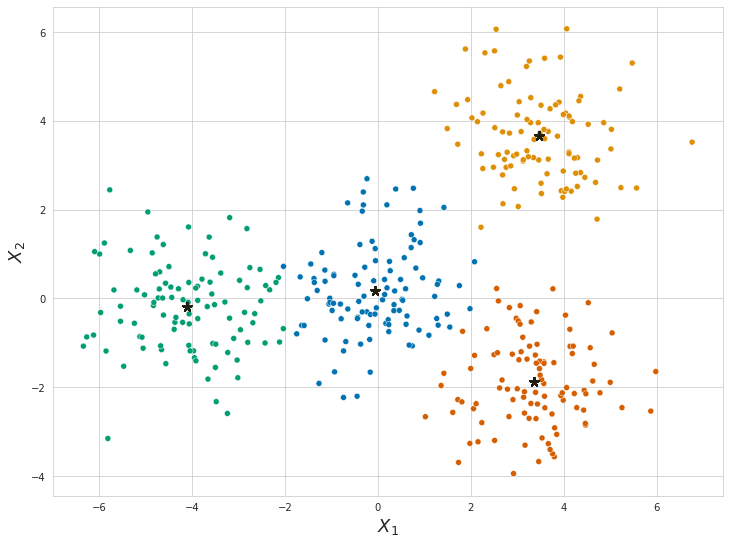

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
# Visualize sample centroid search:
toy_vis_sample.fit(X)

In [15]:
lbl_rand = toy_lbl_random.fit(X)
lbl_sample = toy_lbl_sample.fit(X)
print("See predicted clusters in the case of random centroid search:\n", *lbl_rand.predict(X), '\n')
print("See predicted clusters in the case of sample centroid search:\n", *lbl_sample.predict(X), '\n')

See predicted clusters in the case of random centroid search:
 0 3 1 3 3 3 1 1 3 2 3 3 1 2 3 2 3 2 0 0 3 3 0 2 2 2 1 2 2 3 2 3 3 3 1 1 3 0 1 1 1 3 1 3 0 2 3 1 0 2 0 0 2 2 1 1 1 3 1 2 3 3 1 3 3 1 2 1 1 0 1 0 3 2 0 1 2 3 1 1 1 3 1 1 2 0 3 3 3 3 3 3 2 2 2 3 1 3 2 1 2 1 1 3 3 3 1 3 2 3 0 0 2 0 2 1 0 2 0 2 1 3 1 1 2 0 3 1 2 2 0 1 1 3 2 0 3 0 3 1 1 2 0 1 1 0 0 1 2 2 0 3 3 1 3 1 3 2 0 0 1 1 3 0 2 0 3 3 1 3 0 2 0 2 2 1 0 0 1 2 2 1 0 2 0 2 2 2 0 1 0 2 3 2 3 1 3 0 1 0 2 2 3 2 3 1 2 2 3 0 0 0 1 2 0 0 2 0 3 1 2 3 0 3 0 0 1 3 3 3 2 3 1 2 2 0 1 1 2 0 3 1 3 1 2 3 2 0 1 0 0 1 0 0 1 3 0 1 3 3 0 3 2 0 3 1 0 2 0 3 0 0 3 0 0 2 3 1 3 2 0 2 2 0 3 2 3 2 2 0 1 1 2 1 0 3 0 2 3 0 1 1 2 1 0 1 1 3 2 3 2 0 0 0 2 2 2 3 0 0 0 1 1 2 3 1 0 2 1 2 3 2 2 0 2 0 1 2 0 2 0 3 1 0 1 1 3 2 1 3 0 3 1 0 3 2 3 3 1 0 3 1 1 0 0 1 3 2 3 0 3 3 2 2 0 0 2 0 1 2 0 1 2 0 2 1 1 2 0 2 0 3 1 3 3 3 1 1 2 2 

See predicted clusters in the case of sample centroid search:
 3 2 1 2 2 2 1 1 2 0 2 2 1 0 2 0 2 0 3 3 2 2 3 0 0 0 1 0 0 2 0 2 2 2 1 1 

Our results of two types of clusterization show equal "predictions".

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [16]:
data = load_digits()
X, y = data.data, data.target
#X_test = X[1].reshape(8,8).astype(int)
#X_test

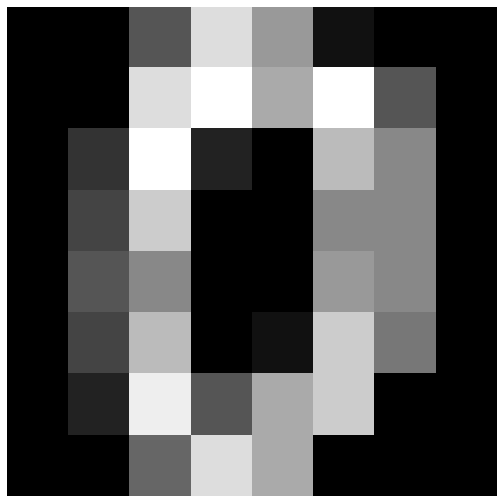

In [17]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [18]:
data = load_digits()
X, y = data.data, data.target
distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['complete', 'average', 'single']
quality = ['silhouette_score', 'homogeneity_score', 'completeness_score', 'v_measure_score']
def algorithm_selection(X, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    
    compare_dataframe = pd.DataFrame({'distances': [item for item in distances for i in range(len(linkages))],
                                  'linkages': [item for i in distances for item in linkages],
                                  'silhouette_score': [0 for _ in range(len(distances)*len(linkages))],
                                  'homogeneity_score': [0 for _ in range(len(distances)*len(linkages))],
                                  'completeness_score': [0 for _ in range(len(distances)*len(linkages))],
                                  'v_measure_score' : [0 for _ in range(len(distances)*len(linkages))]
                                 })
    
    for index, row in compare_dataframe.iterrows():
        aff = row[0]
        link = row[1]
        #pred = AgglomerativeClustering(n_clusters=np.unique(X_r[1]).shape[0], affinity=aff, linkage = link).fit_predict(X_r)
        pred = AgglomerativeClustering(n_clusters=np.unique(y).shape[0],affinity=aff, linkage = link).fit_predict(X)
        
        print(pred)
        #y = X_r[1].astype(int)
        #print(silhouette_score(X_r, pred, metric = aff))
        compare_dataframe.iloc[index,compare_dataframe.columns.get_loc('silhouette_score')] = silhouette_score(X = X, labels = pred, metric = aff)
        compare_dataframe.iloc[index,compare_dataframe.columns.get_loc('homogeneity_score')] = homogeneity_score(y, pred)
        compare_dataframe.iloc[index,compare_dataframe.columns.get_loc('completeness_score')] = completeness_score(y, pred)
        compare_dataframe.iloc[index,compare_dataframe.columns.get_loc('v_measure_score')] = v_measure_score(y, pred)
        
    
    
    return compare_dataframe

algorithm_selection(X, distances, linkages, quality)

[1 0 0 ... 0 3 0]
[0 4 4 ... 4 2 4]
[0 0 0 ... 0 0 0]
[7 0 4 ... 2 2 2]
[0 1 1 ... 1 0 1]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 3 0]
[0 4 4 ... 4 2 4]
[0 0 0 ... 0 0 0]
[7 0 4 ... 2 2 2]
[0 1 1 ... 1 0 1]
[0 0 0 ... 0 0 0]
[0 8 8 ... 8 0 2]
[2 6 1 ... 1 3 1]
[0 0 0 ... 0 0 0]


,distances,linkages,silhouette_score,homogeneity_score,completeness_score,v_measure_score
0,euclidean,complete,0.119271,0.590549,0.637772,0.613253
1,euclidean,average,0.146625,0.655393,0.782342,0.713263
2,euclidean,single,-0.133621,0.005056,0.273755,0.009929
3,l1,complete,0.160617,0.646372,0.686109,0.665648
4,l1,average,0.105238,0.566751,0.778942,0.656117
5,l1,single,-0.203816,0.005102,0.276237,0.010019
6,l2,complete,0.119271,0.590549,0.637772,0.613253
7,l2,average,0.146625,0.655393,0.782342,0.713263
8,l2,single,-0.133621,0.005056,0.273755,0.009929
9,manhattan,complete,0.160617,0.646372,0.686109,0.665648


We see that for all metrics except homogeneity score the best combination of affinity and linkage is **coisine-average** pair. This combinations shows the highst values 0.218, 0.809, 0.72 for silhouette, completeness and v_measure, consequenently. Though the highest value for homogeneity appeared to be for the combination of **euclidean-average**, the second one standing for the former significant combination differes from the highest one only for 0,08 points. 

Thus we can admit that the best combination is seemed to be affinity (distance) equal to **cosine** and linkage equal to **average**.


### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [19]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)
fc_data.dropna(inplace=True)

##### YOUR TURN TO CODE:

First of all, we have to see the overall distributions of our markers' groups. For this several approaches are available, from which **kde** and **boxplot** distribution visualizations are preferable to represent both: the **shape** and **outliers**. However, before the visualization data preparation ought to be provided (wide to long transformation).

In [20]:
fc_data2 = fc_data.reset_index()
fc_data2.columns[1::]
fc_long_M = pd.melt(fc_data2, id_vars='index', value_vars=fc_data2.columns[3::])
fc_long_S = pd.melt(fc_data2, id_vars='index', value_vars=fc_data2.columns[1:3])

Text(0.5, 1.1, 'Histplot visualization of CD-based groups')

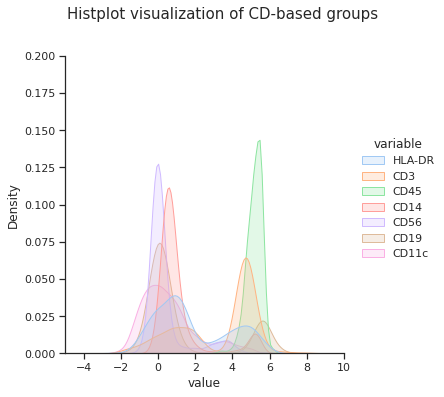

In [21]:
# KDE distplot visualization
sns.set_theme(style="ticks", palette="pastel")
M_d = sns.displot(fc_long_M, x="value", hue="variable", kind = 'kde', fill=True)
M_d.set(ylim=(0,0.2), xlim = (-5, 10))
M_d.fig.suptitle('Histplot visualization of CD-based groups', fontsize = 15, y = 1.1)

Text(0.5, 1.1, 'Histplot visualization of size-based groups')

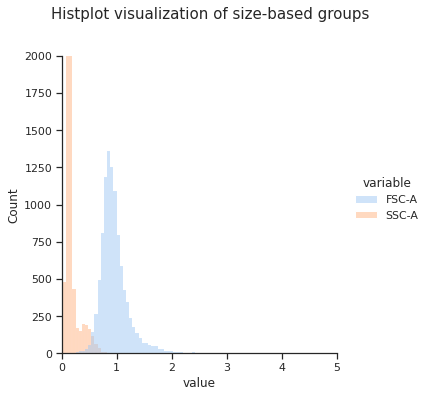

In [22]:
sns.set_theme(style="ticks", palette="pastel")
S_h = sns.displot(fc_long_S, x="value", hue="variable")
S_h.set(ylim=(0,2000), xlim = (0, 5))
S_h.fig.suptitle('Histplot visualization of size-based groups', fontsize = 15, y = 1.1)


From distplots we can see that we have extremely differing sets not only in the shape of distribution, but also in the variance, means and even quantity of values. Intriguinly, the group HLA-DR and CD56 have bimodal distributions, however mean values lies in the variance of others, except CD3 and CD45, cosidering standard deviation. As the shape also differs significantly we could not assign our groups as balanced, cause this phenomena signifies about differing standard deviations among all groups. 

We also can notice, that in the case of size-based groups SSC-A is represented in major by cells with size ~0. And among group FSC-A cells have bigger variance of cell sizes: from ~0 till ~2. Though the majority of FSC-A cells possess size equal to 1. With these data we also could not admit these groups balanced, as our **size-group distributions** differ by **shape, std and means**.

In [ ]:
# Boxplot visualization

Text(0.5, 1.0, 'Boxplot visualization of CD-based groups')

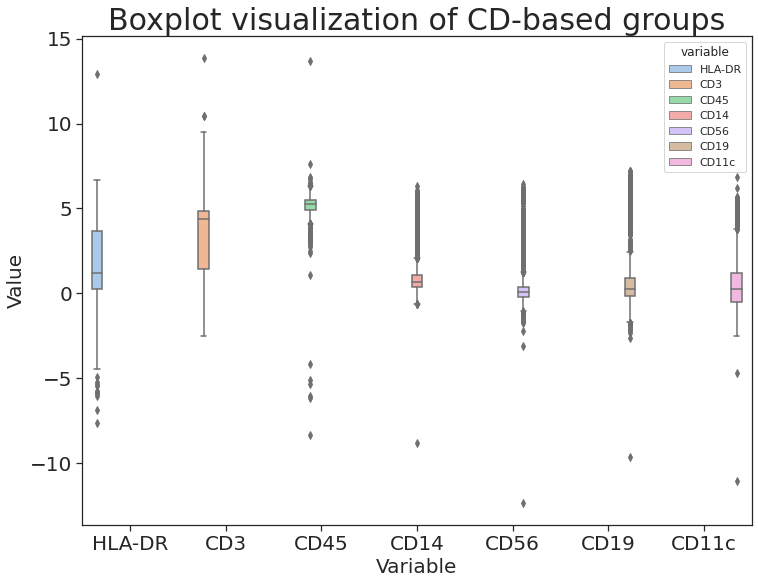

In [23]:
sns.set_theme(style="ticks", palette="pastel")
M = sns.boxplot(x = 'variable', y="value",
            hue="variable",
            data=fc_long_M)
M.set_ylabel('Value',fontsize=20)
M.set_xlabel('Variable',fontsize=20)
M.tick_params(axis='both', labelsize=20)
M.set_title('Boxplot visualization of CD-based groups', fontsize = 30)

[(0.0, 5.0)]

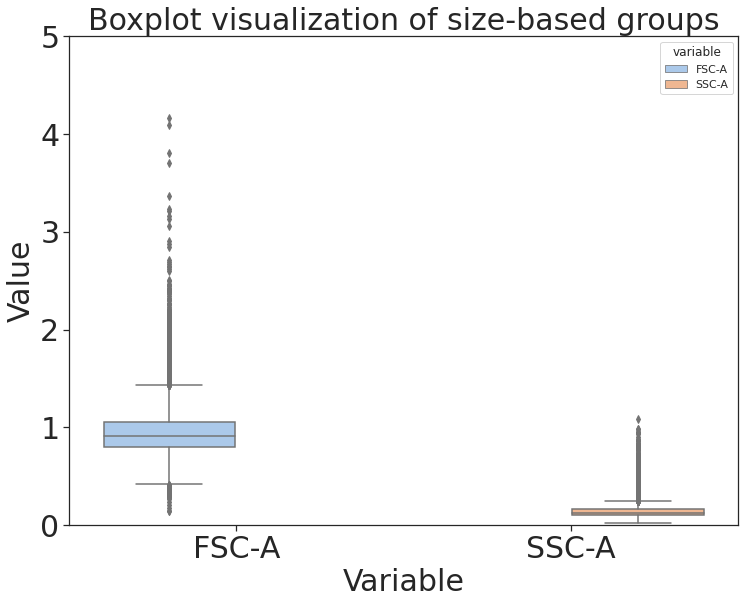

In [24]:
sns.set_theme(style="ticks", palette="pastel")
pl = sns.boxplot(x = 'variable', y="value",
            hue="variable",
            data=fc_long_S)
pl.set_ylabel('Value',fontsize=30)
pl.set_xlabel('Variable',fontsize=30)
pl.tick_params(axis='both', labelsize=30)
pl.set_title('Boxplot visualization of size-based groups', fontsize = 30)
pl.set(ylim = (0,5))

With boxplot we could reveal that our data is enriched by **significant outliers**  in the case of **both**: marke-based groups and size-based groups.

From marker-based groups the ones with **most significant outliers** are <u>*CD45, CD14, CD56, CD19*</u>. Among CD markers only CD3 has less outliers (signifying its distibution as the most balanced). And for CD14, CD56, CD19, including CD11c these outliers lies in the increased values state. The <u>*HLA-DR*</u> group also has several decreased outliers, however thier prevalence is not so significant. 

From size-based groups we can suppose that in both  sizes are described by distributions with significant outliers. 

Overall, this description highligh the higher probability of our data to be inbalanced and even with dubious distributions.

And now - more precisely. Lets look at numbers of our observations.

In [25]:
fc_data.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.962458,0.165415,1.791579,3.280391,5.169845,1.097182,0.412223,1.219683,0.569898
std,0.500012,0.190773,2.027281,2.112079,0.518247,1.375876,1.176967,2.285305,1.502445
min,0.144786,0.021657,-7.634172,-2.517639,-8.329666,-8.833883,-12.358701,-9.640775,-11.085437
25%,0.798804,0.105550,0.275056,1.401943,4.922227,0.389746,-0.195978,-0.146948,-0.498781
50%,0.908574,0.130543,1.194313,4.373660,5.234119,0.672853,0.053267,0.244121,0.272297
75%,1.052034,0.162536,3.696976,4.842212,5.481218,1.065076,0.378576,0.908374,1.220576
max,42.954485,15.460997,12.946668,13.844391,13.710922,6.294236,6.461899,7.208721,6.840864


Herein, our standard deviation confirms the differences of distribution shapes. If size-based groups are more close to each other (at least in the distance of 3 sigmas), CD-based groups (markers) vary more significantly: from 0.5 to 2.28. The only parameters our groups are balanced by is the number of observations. Within **mean, std, min/max** fields the distributions more likely **inbalanced**. 

As our data is highly inbalanced - lets somehow remove outliers at least in several columns (or in average).

For this we will try strict and less strict filtration: >Q3 and \<Q1 thresholds; >(Q3 + 1.5 * IQR) and \<(Q1 - 1.5 * IQR) thresholds.

In [26]:
#Less strict filtration    
cols = [i for i in fc_data.columns] # one or more.

Q1 = fc_data[cols].quantile(0.25)
Q3 = fc_data[cols].quantile(0.75)
IQR = Q3 - Q1

#fc_data_f = fc_data[~((fc_data[cols] < (Q1 - 1.5 * IQR)) |(fc_data[cols] >(Q3 + 1.5 * IQR))).all(axis=1)]
fc_data_f_less = fc_data[~((fc_data[cols] < (Q1)) |(fc_data[cols] >(Q3))).all(axis = 1)]
#fc_data_f = fc_data[~((fc_data[cols] < (Q1)) |(fc_data[cols] >(Q3)))]
fc_data_f_less.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000
mean,0.955174,0.162755,1.779355,3.296662,5.176906,1.084251,0.413320,1.211559,0.552077
std,0.262994,0.112786,2.000262,2.086773,0.430619,1.355925,1.166613,2.274165,1.477835
min,0.144786,0.021657,-4.921411,-2.517639,1.070088,-0.643408,-1.765140,-2.639452,-2.531130
25%,0.799468,0.105558,0.270451,1.439884,4.929453,0.389897,-0.193982,-0.144225,-0.499512
50%,0.908212,0.130371,1.184263,4.381527,5.236380,0.669452,0.053044,0.243717,0.262799
75%,1.048654,0.161543,3.637690,4.843254,5.480972,1.052535,0.374227,0.892782,1.197887
max,4.164550,1.085003,6.678981,8.847605,6.848475,6.294236,6.461899,7.208721,6.840864


In [27]:
# Strict filtration

cols = [i for i in fc_data.columns] # one or more.

Q1 = fc_data['FSC-A'].quantile(0.25)
Q3 = fc_data['FSC-A'].quantile(0.75)
#IQR = Q3 - Q1


fc_data_f_str = fc_data[~((fc_data['FSC-A'] < (Q1)) |(fc_data['FSC-A'] >(Q3)))]
fc_data_f_str.describe()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.914320,0.137590,1.561091,3.478226,5.188074,0.764438,0.426061,1.184376,0.296948
std,0.069212,0.075771,1.944711,2.014534,0.396489,0.905101,1.204723,2.249883,1.208055
min,0.798832,0.041062,-4.380748,-2.455861,2.851020,-0.632298,-1.337412,-2.315996,-2.523402
25%,0.857231,0.101206,0.144825,1.695640,4.958056,0.344880,-0.201164,-0.151946,-0.545220
50%,0.908574,0.124274,1.010587,4.462631,5.250254,0.592338,0.043123,0.226260,0.124136
75%,0.970650,0.148881,2.915649,4.873304,5.478840,0.866456,0.358926,0.858366,0.925210
max,1.052022,0.937794,6.678981,8.687362,5.958468,5.642053,6.461899,6.696526,5.668427


#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [28]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None, aff = 'PCA', link = 'average'):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    
    ## Launch learning process
    pca = PCA().fit(data)
    ## Transform our data based on learnt PCA-division algorithm
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    if type(n_iter) is not int:
        for i in n_iter:
            tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                        n_iter=i, perplexity=perplexity)
            tsne_embedding = tnse.fit_transform(pca_embedding)
            plt.figure()
            sns.scatterplot(x=tsne_embedding[:, 0],
                            y=tsne_embedding[:, 1],
                            hue=color, palette="colorblind")
            plt.xlabel("$TSNE_1$", fontsize=18)
            plt.ylabel("$TSNE_2$", fontsize=18)
            plt.show()
        #plt.show()
    
    else:
        tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
        tsne_embedding = tnse.fit_transform(pca_embedding)
        plt.figure()
        sns.scatterplot(x=tsne_embedding[:, 0],
                        y=tsne_embedding[:, 1],
                        hue=color, palette="colorblind")
        plt.xlabel("$TSNE_1$", fontsize=18)
        plt.ylabel("$TSNE_2$", fontsize=18)
        plt.title(f"Agglomerative clusterin with affinity {aff} and linkage {link}")
        plt.show()
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

**For strictly filtered dataset**

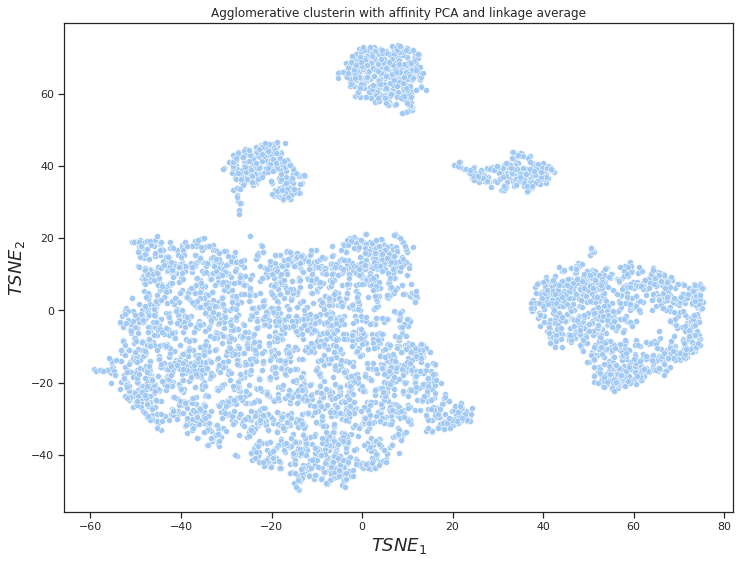

In [29]:
tsne_res = plot_tsne(fc_data_f_str, n_iter = 1000)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

**For less filtered dataset**

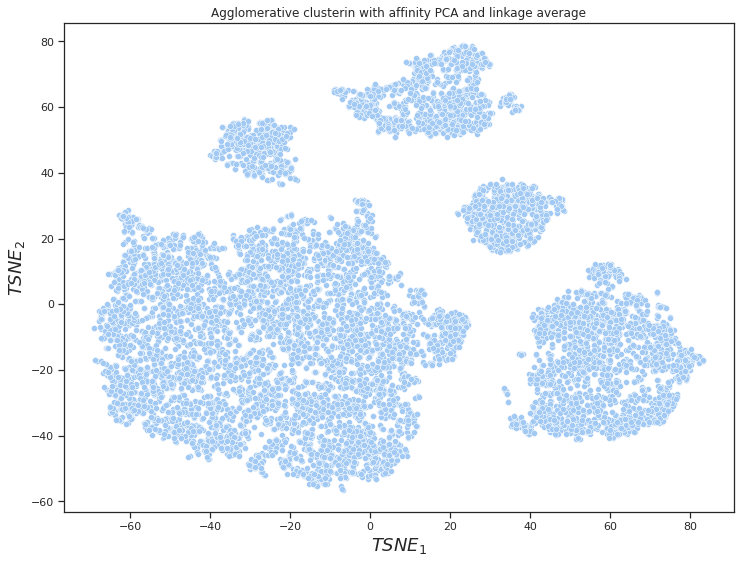

In [30]:
tsne_res_less = plot_tsne(fc_data_f_less, n_iter = 1000)

It can be noticed that when the filtration is more strict our clusters seem to be more obvious and clear in comparison with less strict filtration. If the threshold is increased (more observations are left) the clusters possess smaller distance between each other, making the clusterisation and classification more difficult. On the contrary, when the threshold is decreased (less observation would be included) clusters are more clear and the overall clusterisation tends to mao target classification (we see that exactly 4 clusters are going to be formed).

In [31]:
#quality = ['silhouette_score', 'homogeneity_score', 'completeness_score', 'v_measure_score']
def choose_cluster_method(X):
    cp_df = pd.DataFrame({'Method': ['KMeans', 'complete', 'single', 'average'],
                        'euclidean': [[0] for _ in range(4)],
                        'l1': [[0] for _ in range(4)],
                        'l2': [[0] for _ in range(4)],
                        'manhattan': [[0] for _ in range(4)],
                        'cosine': [[0] for _ in range(4)]
                         })
    
    cur_K = KMeans(n_clusters = len(X.columns), random_state = 10).fit_predict(X)
    cp_df['euclidean'][0] = silhouette_score(X, cur_K)
    #print(cp_df)
    for each in cp_df.columns[1::]:
        for l, val in enumerate(cp_df['Method'][1::]):
            #print(val)
            cur_com = silhouette_score(X, AgglomerativeClustering(n_clusters= 4,affinity=each, linkage = val).fit_predict(X), metric = each)
            cp_df[each][l+1] = cur_com
       
    return cp_df

In [32]:
choose_cluster_method(fc_data_f_str)

,Method,euclidean,l1,l2,manhattan,cosine
0,KMeans,0.259636,[0],[0],[0],[0]
1,complete,0.626019,0.611355,0.626019,0.611355,0.853284
2,single,0.550682,0.406542,0.550682,0.406542,0.661291
3,average,0.600505,0.621,0.600505,0.621,0.853284


From hyperparameters and methods analysis we can suggest that agglomerative clustering with cosine distance and average or complete linkages better describes the data the best (the closer silhouette score to 1, the more accurate clusterisation of groups into one common group is).

Thus for t-SNE visualization AgglomerativeClustering with distance = cosine and linkage = average will be chosen. Lets also see how our predictions differs depending on the algorithm.

Firstly, **strictly filtered** dataset will be analyzed by the accuracy of clusterisation in the sense of classification.

In [33]:
pred_cos_av = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage = 'average').fit_predict(fc_data_f_str)
fit_cos_av = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage = 'average').fit(fc_data_f_str)
pred_cos_comp = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage = 'average').fit_predict(fc_data_f_str)


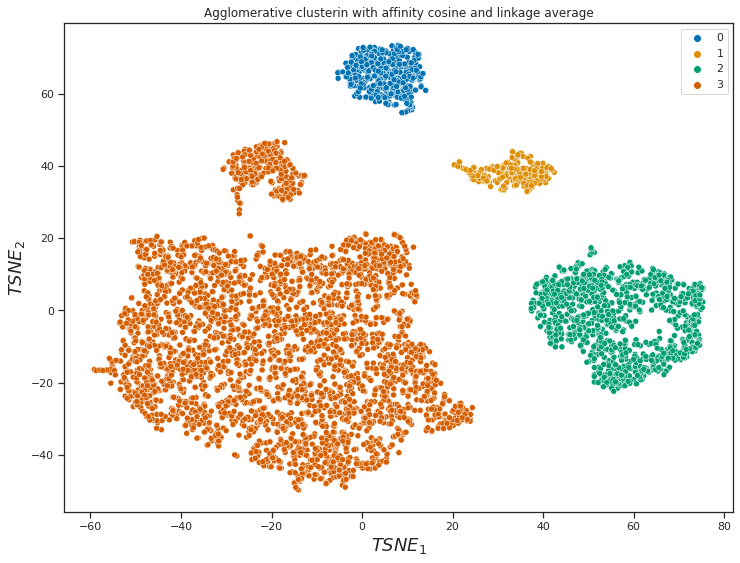

array([[ 45.13136041,  -3.03391106],
       [ 64.08475477, -16.50603047],
       [ 73.41121395, -11.18528446],
       ...,
       [-26.05529111, -32.04095772],
       [  3.60241205,  66.38356538],
       [  3.5601387 ,  59.06790673]])

In [34]:
plot_tsne(fc_data_f_str, color=pred_cos_av.astype(int), aff = 'cosine')

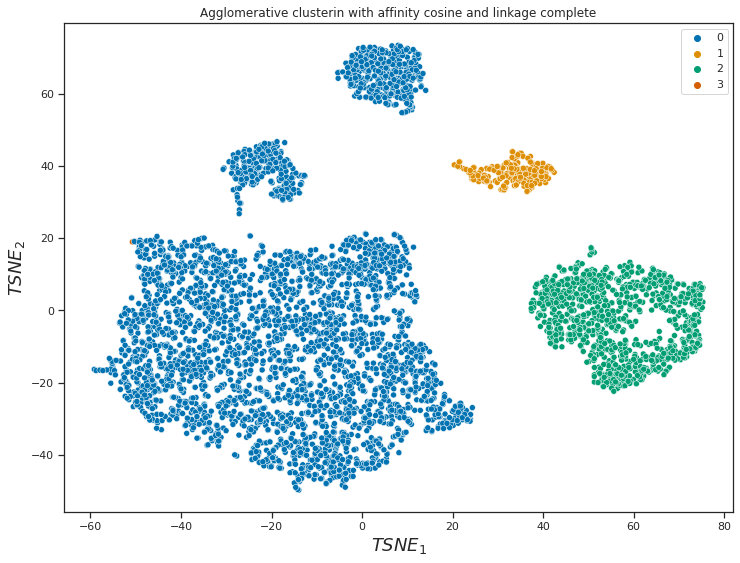

array([[ 45.13136041,  -3.03391106],
       [ 64.08475477, -16.50603047],
       [ 73.41121395, -11.18528446],
       ...,
       [-26.05529111, -32.04095772],
       [  3.60241205,  66.38356538],
       [  3.5601387 ,  59.06790673]])

In [37]:
plot_tsne(fc_data_f_str, color=pred_cos_comp.astype(int), aff = 'cosine', link = 'complete')

We see, that even silhouette score is the same for both: cosine + average and cosine + complete, the better clusterisation. Thus for the following analysis cosine + average will be used. 

What about less filtered dataset? Lets see how it's classified:

In [38]:
pred_cos_av_less = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage = 'average').fit_predict(fc_data_f_less)
fit_cos_av_less = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage = 'average').fit(fc_data_f_less)
pred_cos_comp_less = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage = 'average').fit_predict(fc_data_f_less)


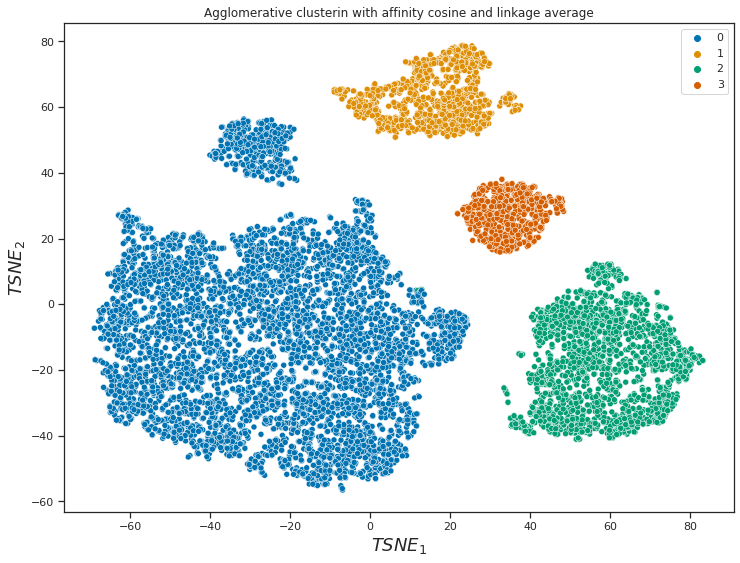

array([[ 42.04944429,  29.8137303 ],
       [ 53.65945407, -20.53569238],
       [-51.310569  , -19.80922469],
       ...,
       [ -4.04833476,  61.11198774],
       [ 34.43626526,  24.30390588],
       [ 40.21355224,  24.38790699]])

In [39]:
plot_tsne(fc_data_f_less, color=pred_cos_av_less.astype(int), aff = 'cosine')

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

From three attempts of clusterization optimisation we could suppose that either chosen clusterization method is far from proper one (cosine + average), or our data by default is noising enough thus any clustering would not show the perfect one. The later, according to the EDA (even after outliers drop), seems to be more possible. 

If we compare chosen methods (cosine/euclidean/l2 + average), we see that the 2d and the 3d methods shows the same results of clusterization and class assign. The former differs from the previous only in the assigned to each cluster class. And with all options we still have some "strangers" inside most of clusters (small points of different color).

Thus we could tell that in analyzed situations part of clusters are clear and the rest - disrupted by "strangers". 

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

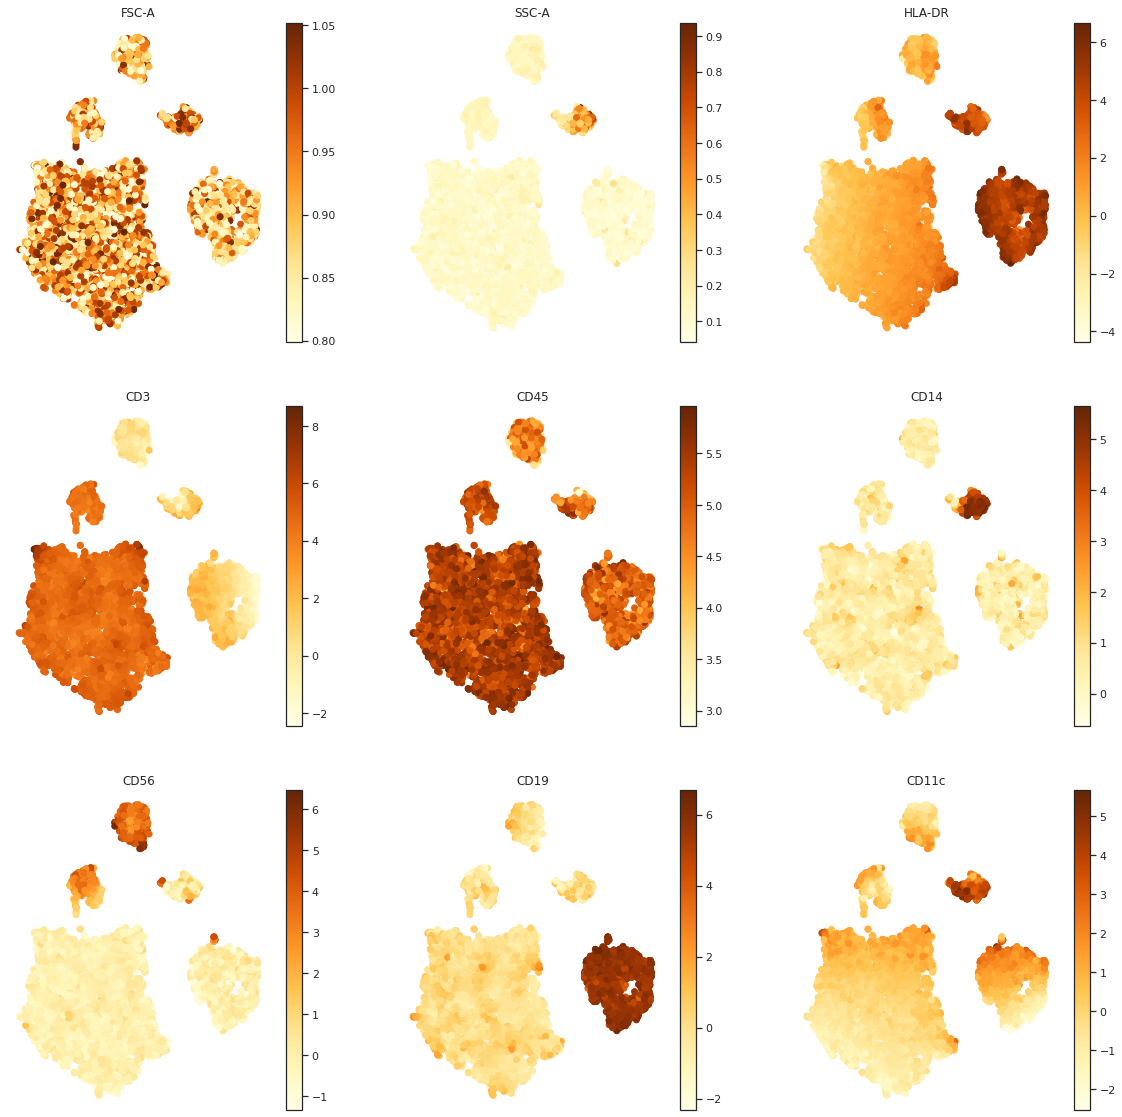

In [40]:
# For strictly filtered data
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_f_str.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_f_str[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

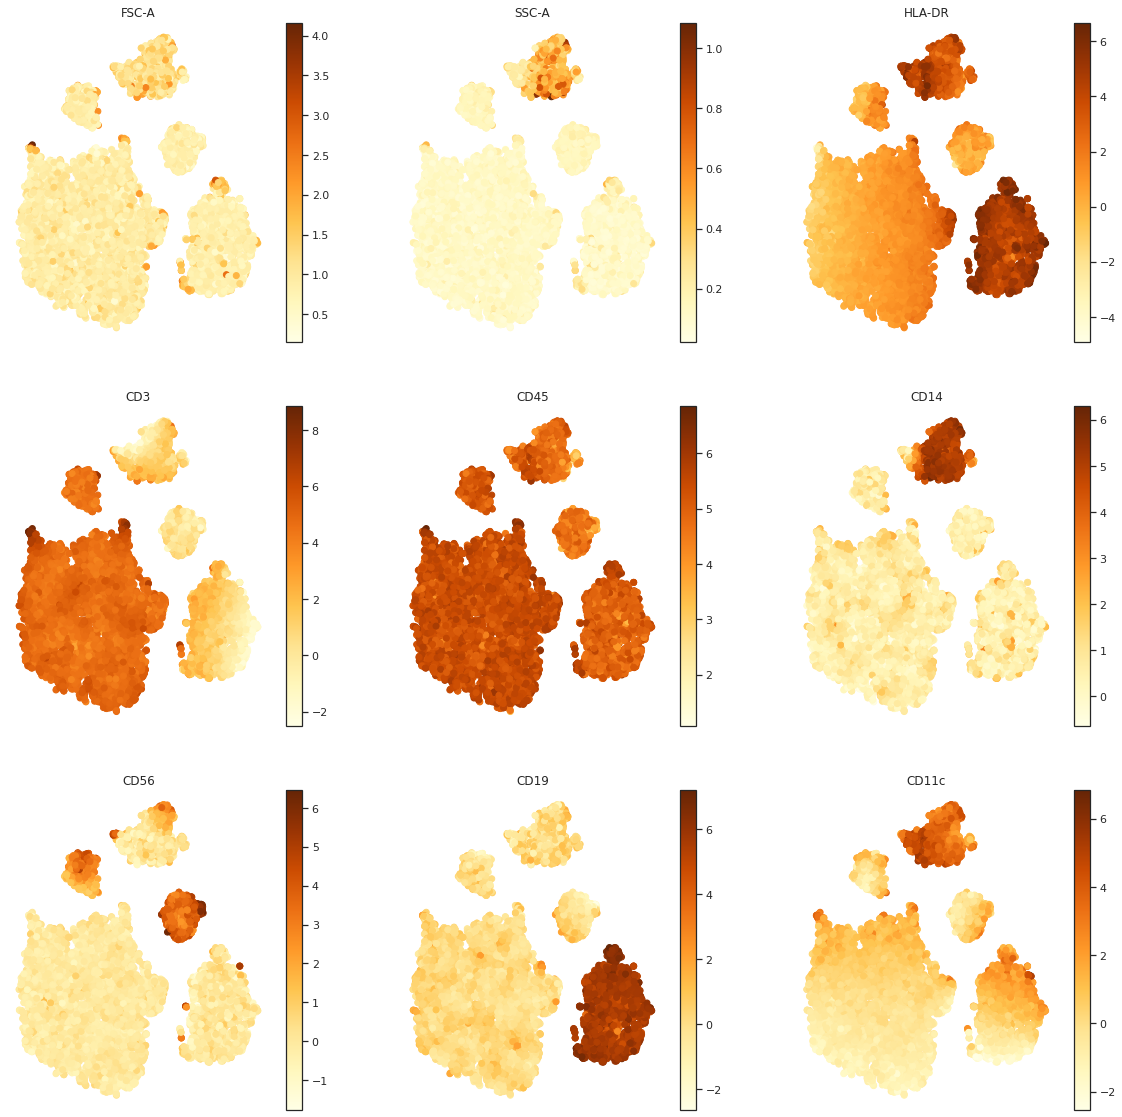

In [41]:
# For less filtered data
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_f_less.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res_less[:, 0], tsne_res_less[:, 1], 
                         c=fc_data_f_less[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

If we analyze how markers expression distributed in different in volume datasets, we can notice that more fulfilled one shows the better expression patterns. At least the genetic marker of cell size in the case of less filtered dataset does not show the mozaic pattern - thus, we can admitt that for classification more descriptive dataset is preferable.

In [42]:
# According to less filtered dataset
cols_0 = ['CD3', 'CD45', 'HLA-DR'] 
cols_1 = ['HLA-DR', 'CD11c','SSC-A'] 
cols_2 = ['CD19', 'CD45','HLA-DR']
cols_3 = ['CD45', 'CD56']

In [43]:
cell_type_cluster_map2 ={0: cols_0, 
                         1: cols_1, 
                         2: cols_2, 
                         3: cols_3}

In [44]:
cell_type_cluster_map2.keys()

dict_keys([0, 1, 2, 3])

In [45]:
labeled_fc_data = fc_data_f_less.assign(Population=fit_cos_av_less.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map2)
labeled_fc_data2 = labeled_fc_data

Посчитайте, как распределены типы клеток:

In [46]:
labeled_fc_data2['Type'] = [None for _ in range(len(labeled_fc_data2))]

In [47]:
labeled_fc_data2
#cell_type_cluster_map2.keys()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c,Population,Type
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406,"[CD45, CD56]",None
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039,"[CD19, CD45, HLA-DR]",None
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832,"[CD3, CD45, HLA-DR]",None
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960,"[CD3, CD45, HLA-DR]",None
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591,"[CD19, CD45, HLA-DR]",None
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737,"[HLA-DR, CD11c, SSC-A]",None
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795,"[CD3, CD45, HLA-DR]",None
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294,"[HLA-DR, CD11c, SSC-A]",None
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239,"[CD45, CD56]",None


In [48]:
for i in labeled_fc_data2.index:
    if labeled_fc_data2['Population'][i] == cols_0:
        labeled_fc_data2['Type'][i] = 'B_cells'
    elif labeled_fc_data2['Population'][i] == cols_1:
        labeled_fc_data2['Type'][i] = 'T_cells'
    elif labeled_fc_data2['Population'][i] == cols_2:
        labeled_fc_data2['Type'][i] = 'Monocytes'
    elif labeled_fc_data2['Population'][i] == cols_3:
        labeled_fc_data2['Type'][i] = 'Other cells'

In [49]:
labeled_fc_data2.replace(to_replace='None', value=np.nan).dropna(inplace = True)

In [50]:
labeled_fc_data2.Type.value_counts()

B_cells        6209
Monocytes      2007
T_cells        1058
Other cells     631
Name: Type, dtype: int64

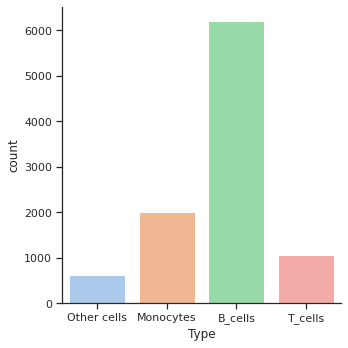

In [51]:
sns.catplot(data = labeled_fc_data2, x = 'Type', kind="count",palette="pastel")

From chosen types of cells we see that our data is represented mostly by **B cells**. Among all cells **6209** of them seems to be <u>B cells</u>. We also see that our population is represented by <u>monocytes</u> cells in the volume of **2007**. However, the last - <u>T cells</u> and <u>other cells</u> -  are met less often.

In [52]:
labeled_fc_data.to_csv('fc_data_types.csv')

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [53]:
# Make integral class labels
X = labeled_fc_data2.copy()
for i in X.index:
    if X['Population'][i] ==  cols_0 :
        X['Type'][i] = 0
    elif X['Population'][i] == cols_1:
        X['Type'][i] = 1
    elif X['Population'][i] == cols_2:
        X['Type'][i] = 2
    elif X['Population'][i] == cols_3:
        X['Type'][i] = 3

In [54]:
# Check if replacement worked
X

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c,Population,Type
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406,"[CD45, CD56]",3
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039,"[CD19, CD45, HLA-DR]",2
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832,"[CD3, CD45, HLA-DR]",0
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960,"[CD3, CD45, HLA-DR]",0
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591,"[CD19, CD45, HLA-DR]",2
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.180762,0.441445,2.437344,1.526085,4.455114,4.880495,0.347480,-0.591343,2.857737,"[HLA-DR, CD11c, SSC-A]",1
9996,0.768279,0.111863,0.812236,4.254496,5.008437,1.303261,-0.130244,0.344169,-0.626795,"[CD3, CD45, HLA-DR]",0
9997,1.314964,0.233584,4.144130,1.311947,5.340263,1.598675,-0.287353,-0.887078,4.369294,"[HLA-DR, CD11c, SSC-A]",1
9998,0.894135,0.137300,-0.226186,0.246804,4.430212,0.457881,2.404284,-0.112999,0.069239,"[CD45, CD56]",3


Before classifying train and test sets have to be assigned. We would teach our model on train set and then predict for test set.

In [55]:
# Train and test set splitting
fc_tr, fc_tst, y_tr, y_tst  = train_test_split(np.array(X.iloc[:,0:9]),np.array(X.Type).reshape(-1).astype(int), test_size = 0.33, random_state = 111)

#### Logistic regression classification:

As we analyze dataset with multiple classification, in the case of logistic regression it has to be assigned. Thus additional argument "multi_class" shoud be set as **'multinomial'** during model creation.

*Upload several methods and classes for LR multiclass quality estimation*

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize

Build **multiclass** <u>logistic regression model</u> and teach it.

In [57]:
lr_model = LogisticRegression(multi_class = 'multinomial')
lr_model.fit(fc_tr, y_tr)

LogisticRegression(multi_class='multinomial')

Make classification for test data by <u>trained</u> model.

In [58]:
y_pred = lr_model.predict(fc_tst)

Estimate the quality of our multiclass logistic regression classifier:

In [59]:
print(f'Our logistic regression model has F1 score {f1_score(y_tst,y_pred.astype(int), average = "macro")} and accuracy {accuracy_score(y_tst,y_pred.astype(int))}')

Our logistic regression model has F1 score 0.9993373349896213 and accuracy 0.9993881921076782


Though we have a multifactor classification, we can analyze FP/TP rate with ROC_AUC curves for each class against others.

Binarize data to have each class independent classification and count AUC score.

In [60]:
y_roc = label_binarize(np.array(X.Type).reshape(-1).astype(int), classes=[0,1,2,3])
fc_tr_roc, fc_tst_roc, y_tr_roc, y_tst_roc  = train_test_split(np.array(X.iloc[:,0:9]),y_roc, test_size = 0.33, random_state = 111)
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(fc_tr_roc, y_tr_roc).decision_function(fc_tst_roc)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_tst_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Iterate over each class and plot curves:

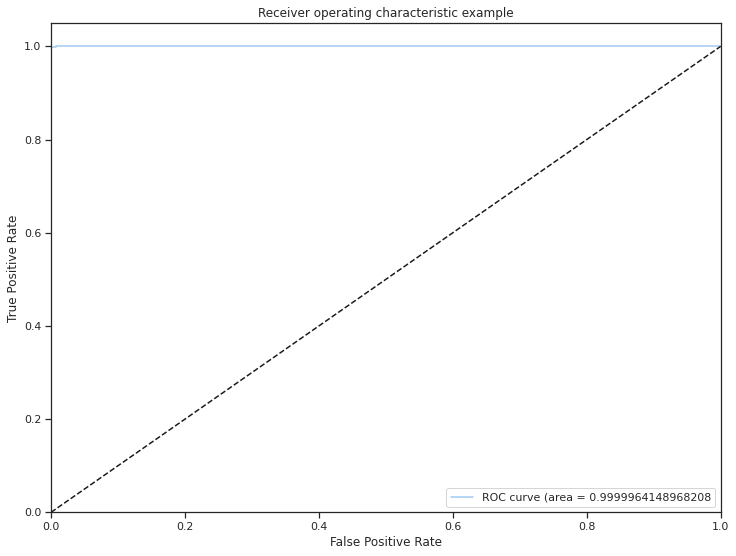

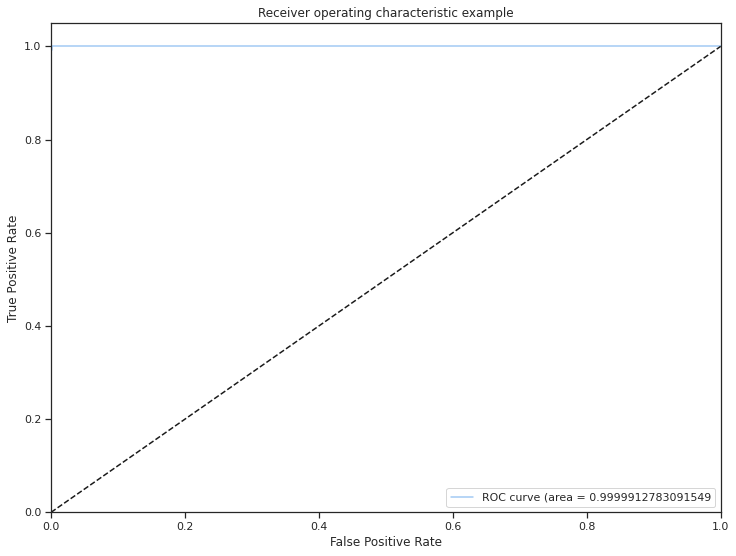

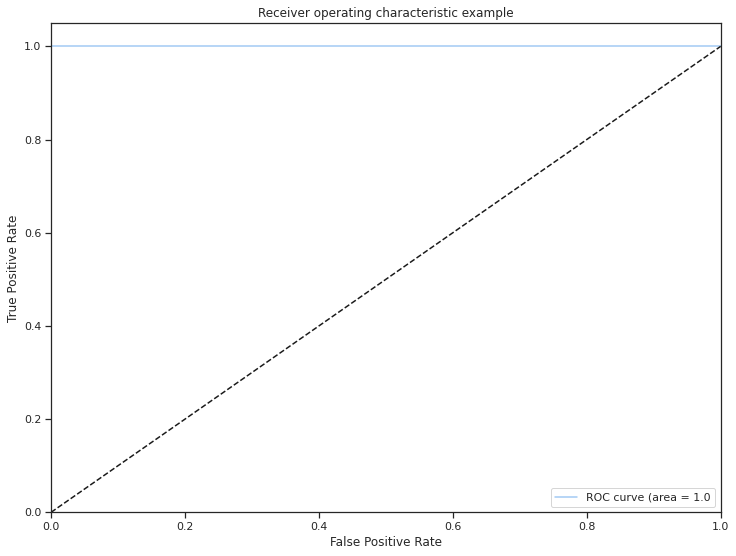

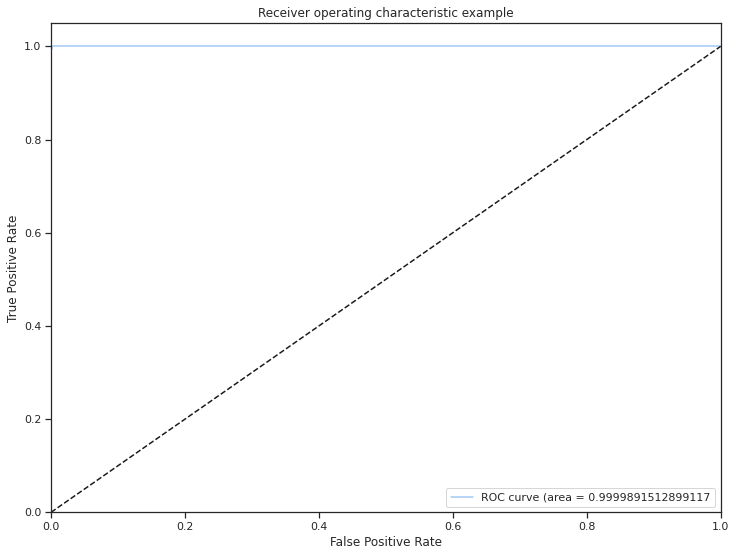

In [61]:
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### KNN classification:

As KNN algorithm is sensitive to number of neighbors, we will analyze how our model predicts regarding number of neighbors taken into account. 

In [62]:
k_size = pd.DataFrame({'neighbors':[1, 10, 20, 30, 40, 50, 60],
                      'f1_score':[0 for _ in range(7)],
                      'accuracy':[0 for _ in range(7)]})

In [63]:
for i, elem in enumerate([1, 10, 20, 30, 40, 50, 60]):
    knn_cl = KNeighborsClassifier(n_neighbors = elem)
    knn_cl.fit(fc_tr, y_tr)
    knn_pred = knn_cl.predict(fc_tst)
    k_size.iloc[i,1] = f1_score(y_tst, knn_pred, average = 'macro')
    k_size.iloc[i,2] = accuracy_score(y_tst, knn_pred)

In [64]:
k_size

,neighbors,f1_score,accuracy
0,1,0.999752,0.999694
1,10,0.999751,0.999694
2,20,0.999751,0.999694
3,30,0.999751,0.999694
4,40,0.999336,0.999388
5,50,0.999336,0.999388
6,60,0.999336,0.999388


We see that for our data KNN algorithm of classification appeared to be better. Even we analyzed only two methods of classification and both of them showed high F1 score, features of modeles were noticed. Logistic regression when used for multiclass classification shows worse specificity, however when it's applied on binarized for each class dataset the quality metric are higher.



### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**